# P7 OLAP Analysis: Finding the Most Profitable Day of the Week for Sales

Author: Alissa Beaderstadt

Date: 04-20-2025

Business Goal: Identify the most profitable day of the week for sales



# Introduction

Objective: The goal of this project is to use OLAP techniques to analyze sales data and identify which day of the week consistently drives the highest revenue. By slicing and dicing the data by day, product category, and customer activity, we aim to uncover patterns that can support smarter business decisions like when to schedule more staff or launch targeted promotions.

Data Source: The data used in this notebook came from my smart_sales.db SQLite database. 

Tools Used: I'm using Python, sqlite, pandas, seaborn, and matplotlib in a Jupyter Notebook.

# Imports
   Below are the necessary imports for this notebook.

In [192]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database

In [193]:
# Connect to the smart_sales database
conn = sqlite3.connect(r"C:\Projects\smart-store-beaderstadt\data\dw\smart_sales.db")


cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in smart_sales.db:", tables)


Tables in smart_sales.db: [('customers',), ('products',), ('sales',)]


# Load Data

In [194]:
# Load and Inspect Customers Data
customers_df = pd.read_sql_query("SELECT * FROM customers", conn)
print("Customers Data (First 5 Rows):")
print(customers_df.head())
print("\nCustomers Data Summary Statistics:")
print(customers_df.describe())

Customers Data (First 5 Rows):
   customer_id           name region   join_date  loyalty_points  \
0         1001  William White   East  11/11/2021            1256   
1         1002   Wylie Coyote   East   2/14/2023             105   
2         1003      Dan Brown   West  10/19/2023             876   
3         1004      Chewbacca   West   11/9/2022              95   
4         1005         Dr Who  North   8/18/2023             333   

  preferred_contact_method standard_date_time  
0                     Text         2021-11-11  
1                     Call         2023-02-14  
2                    Email         2023-10-19  
3                     Text         2022-11-09  
4                     None         2023-08-18  

Customers Data Summary Statistics:
       customer_id  loyalty_points
count    11.000000       11.000000
mean   1006.000000     1036.000000
std       3.316625     1170.179046
min    1001.000000       95.000000
25%    1003.500000      241.500000
50%    1006.000000      79

In [195]:
# Load and Inspect Products Data
products_df = pd.read_sql_query("SELECT * FROM products", conn)
print("\nProducts Data (First 5 Rows):")
print(products_df.head())
print("\nProducts Data Summary Statistics:")
print(products_df.describe())


Products Data (First 5 Rows):
   product_id product_name     category  unit_price  year_added supplier
0         101       laptop  Electronics      793.12        2012    Apple
1         102       hoodie     Clothing       39.10        2018     Nike
2         103        cable  Electronics       22.76        2023     Dell
3         104          hat     Clothing       43.10        2000   Adidas
4         105     football       Sports       19.78        2010   Wilson

Products Data Summary Statistics:
       product_id  unit_price   year_added
count     8.00000    8.000000     8.000000
mean    104.50000  135.802500  2013.625000
std       2.44949  266.823468     7.998884
min     101.00000   12.560000  2000.000000
25%     102.75000   22.015000  2009.500000
50%     104.50000   41.100000  2013.000000
75%     106.25000   72.510000  2019.250000
max     108.00000  793.120000  2024.000000


In [196]:
# Load and Inspect Sales Data
sales_df = pd.read_sql_query("SELECT * FROM sales", conn)
print("\nSales Data (First 5 Rows):")
print(sales_df.head())
print("\nSales Data Summary Statistics:")
print(sales_df.describe())

# Close the connection
conn.close()


Sales Data (First 5 Rows):
   sale_id  customer_id  product_id  store_id  campaign_id  sale_amount  \
0      550         1008         102       404            0        39.10   
1      551         1009         105       403            0        19.78   
2      552         1004         107       404            0       335.10   
3      553         1006         102       406            0       195.50   
4      554         1005         102       405            0       117.30   

    sale_date  discount_percent     state  
0  2024-01-06              0.25    Kansas  
1  2024-01-06              0.15  Missouri  
2  2024-01-16              0.50      Iowa  
3  2024-01-16              0.09  Nebraska  
4  2024-01-25              0.20      Ohio  

Sales Data Summary Statistics:
          sale_id  customer_id  product_id    store_id  campaign_id  \
count   94.000000    94.000000   94.000000   94.000000    94.000000   
mean   596.500000  1005.723404  104.393617  403.319149     0.425532   
std     27.2

# Merge Dataframes

In [197]:
# Merge the sales and customers DataFrame on 'customer_id'
sales_customers_df = pd.merge(sales_df, customers_df, on='customer_id', how='inner')

# Merge the above result with products data on 'product_id'
final_df = pd.merge(sales_customers_df, products_df, on='product_id', how='inner')

# Display the first few rows of the merged DataFrame
print("Merged DataFrame (First 5 Rows):")
print(final_df.head())

# Get a summary of the merged data
print("\nMerged DataFrame Summary Statistics:")
print(final_df.describe())

Merged DataFrame (First 5 Rows):
   sale_id  customer_id  product_id  store_id  campaign_id  sale_amount  \
0      550         1008         102       404            0        39.10   
1      551         1009         105       403            0        19.78   
2      552         1004         107       404            0       335.10   
3      553         1006         102       406            0       195.50   
4      554         1005         102       405            0       117.30   

    sale_date  discount_percent     state           name region  join_date  \
0  2024-01-06              0.25    Kansas     Tony Stark  North   5/1/2020   
1  2024-01-06              0.15  Missouri   Jason Bourne   West  12/1/2020   
2  2024-01-16              0.50      Iowa      Chewbacca   West  11/9/2022   
3  2024-01-16              0.09  Nebraska  Tiffany James  South   6/7/2021   
4  2024-01-25              0.20      Ohio         Dr Who  North  8/18/2023   

   loyalty_points preferred_contact_method stan

# Analysis: Exploring Day of Week Sales
(Slicing) This section focuses on analyzing customer spending behavior for each day of the week.

In [198]:
# Make sure sale_date is in datetime format
final_df['sale_date'] = pd.to_datetime(final_df['sale_date'])

# Add a column for day of the week
final_df['day_of_week'] = final_df['sale_date'].dt.day_name()

# Group to see total sales by day of the week
sliced_summary = final_df.groupby('day_of_week')['sale_amount'].sum().reset_index()

# Optional: Sort days (Monday to Sunday)
import pandas as pd
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sliced_summary['day_of_week'] = pd.Categorical(sliced_summary['day_of_week'], categories=day_order, ordered=True)
sliced_summary = sliced_summary.sort_values('day_of_week')

# Display
print("Total Sales by Day of Week:")
print(sliced_summary)

Total Sales by Day of Week:
  day_of_week  sale_amount
1      Monday     20944.24
5     Tuesday      9463.48
6   Wednesday     21353.82
4    Thursday     25398.98
0      Friday      8617.76
2    Saturday     12528.52
3      Sunday     10249.54


# Visualization: Total Sales by Day of Week:

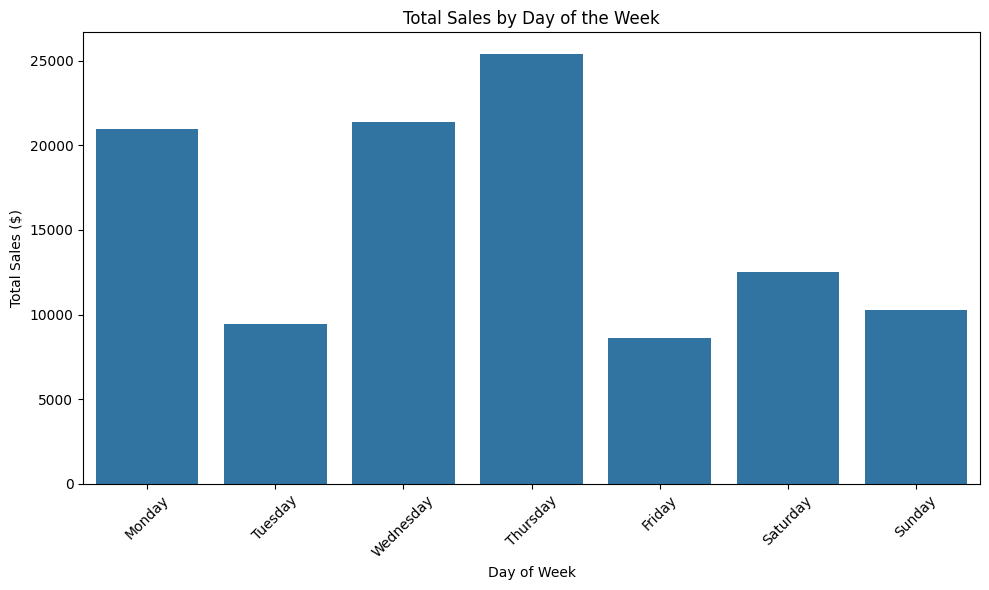

In [199]:
# Create bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=sliced_summary, x='day_of_week', y='sale_amount')

# Add labels and title
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

## Observation: 
Thursday stands out as the highest sales day with 25,398.98, while Friday sees the lowest at 8,617.76. Monday and Wednesday also show strong sales figures, suggesting consistent activity early and mid week

# Analysis: Product Category Performance by Day
(Dicing) This analysis breaks down the sales data by product category within each day. 

Sales by Day of Week and Product Category:
   day_of_week     category  sale_amount
0       Friday     Clothing      1883.14
1       Friday  Electronics      6596.16
2       Friday       Sports       138.46
3       Monday     Clothing       957.68
4       Monday  Electronics     19986.56
5     Saturday     Clothing       642.28
6     Saturday  Electronics     11866.46
7     Saturday       Sports        19.78
8       Sunday     Clothing      2025.70
9       Sunday  Electronics      8144.72
10      Sunday       Sports        79.12
11    Thursday     Clothing      4414.92
12    Thursday  Electronics     20984.06
13     Tuesday     Clothing      1792.86
14     Tuesday  Electronics      7551.94
15     Tuesday       Sports       118.68
16   Wednesday     Clothing      1708.30
17   Wednesday  Electronics     19329.04
18   Wednesday       Sports       316.48


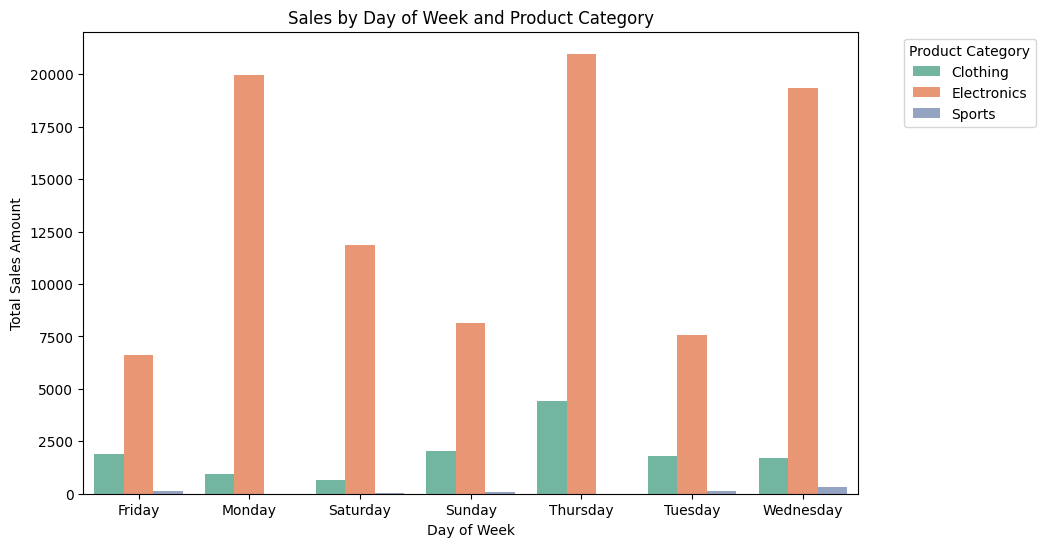

In [200]:
# Group by Day of Week and Product Category to see total sales
day_category_sales = final_df.groupby(['day_of_week', 'category'])['sale_amount'].sum().reset_index()

# Display the grouped data
print("Sales by Day of Week and Product Category:")
print(day_category_sales)

# Plot the sales data to visualize performance by product category and day of week
plt.figure(figsize=(10, 6))
sns.barplot(data=day_category_sales, x='day_of_week', y='sale_amount', hue='category', palette='Set2')
plt.title('Sales by Day of Week and Product Category')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales Amount')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Observation:
The sales data reveals that Electronics consistently outperform other categories across all days of the week, with the highest sales on Monday and Thursday. Clothing also shows strong sales, particularly on Thursday and Sunday, but is generally outpaced by Electronics. Sports products have the lowest sales across all days, with minimal contribution to total sales.

# Analysis: Customer Contributions by Day of Week and Product Category
(Dicing) This analysis breaks down how individual customers' purchases impact total sales by day and category.

Customer Contributions by Day of Week and Product Category:
   day_of_week     category  customer_id  sale_amount
0       Friday     Clothing         1006       670.20
1       Friday     Clothing         1008       431.00
2       Friday     Clothing         1009       781.94
3       Friday  Electronics         1001      6344.96
4       Friday  Electronics         1002       125.60
..         ...          ...          ...          ...
70   Wednesday  Electronics         1008       800.82
71   Wednesday  Electronics         1010       182.08
72   Wednesday       Sports         1005       178.02
73   Wednesday       Sports         1006        39.56
74   Wednesday       Sports         1011        98.90

[75 rows x 4 columns]


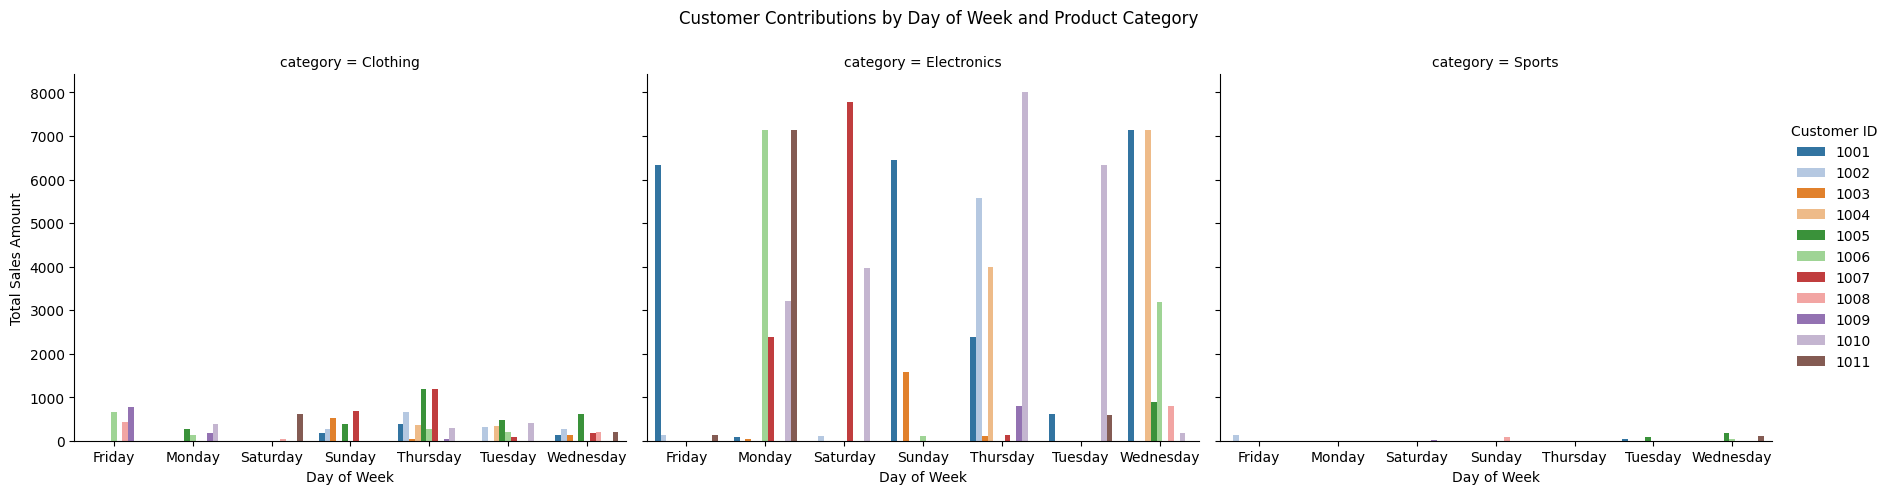

In [201]:
# Group by Day of Week, Category, and Customer ID to see customer contributions
customer_day_category_sales = final_df.groupby(['day_of_week', 'category', 'customer_id'])['sale_amount'].sum().reset_index()

# Display the data for customer contributions by day and product category
print("Customer Contributions by Day of Week and Product Category:")
print(customer_day_category_sales)

g = sns.catplot(
    data=customer_day_category_sales,
    x='day_of_week',
    y='sale_amount',
    hue='customer_id',
    col='category',
    kind='bar',
    height=5,
    aspect=1.2,
    palette='tab20'
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Customer Contributions by Day of Week and Product Category')
g.set_axis_labels("Day of Week", "Total Sales Amount")
g._legend.set_title("Customer ID")


## Observation:
These charts show how individual customers contribute to total sales across different days of the week and product categories. A few standout customers, such as 1001 and 1010, consistently drive higher sales especially in the electronics category. In contrast, the sports category shows relatively low sales across all days of the week.